# Python Practice Lecture 12 MATH 342W Queens College - Overfitting
## Author: Amir ElTabakh
## Date: March 10, 2021

## Agenda:
* Correlation zero means orthogonality
* Random correlations are non-zero
* The monotonicity of SSR (or $R^2$) with more features
* Overfitting
* Assessing overfitting in practice

## Correlation zero means orthogonality

Let's generate some fake data. In this example we'll have one predictor which will be orthogonal to the centered response. We enforce the response to be centered by adding a column of 1's:

In [1]:
# importing dependencies
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # calculates RMSE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generating x and y
n = 100
p = 2

X = [[1, np.random.normal(0, 1), np.random.normal(0, 1)] for i in range(n)] # round to nearest 5th decimal place
Q, R = np.linalg.qr(X)

y = Q[:, 2]
x = Q[:, 1]

# output first 5 elements of x and y
print(x[0:5])
print(y[0:5])

[ 0.0417359  -0.01932189  0.15401569  0.13356953  0.000608  ]
[ 0.09621858 -0.08124517 -0.10176346 -0.09950284  0.02415923]


Let's make sure it's orthogonal.

In [3]:
x @ y

-2.42861286636753e-17

If they're orthogonal and y is mean-centered, what is the correlation?

In [5]:
np.corrcoef(x, y)

array([[ 1.00000000e+00, -1.10017467e-17],
       [-1.10017467e-17,  1.00000000e+00]])

If the correlation is 0, what is $b_1$, the slope? It has to be zero. Thus $b_0$ has to be $\bar{x}$. Since x was also orthogonalized to the vector of 1's, it's centered and hence has average = 0. So both intercept and slope are 0:

What is $b$?

In [6]:
# initialize model
model = LinearRegression(fit_intercept = True)

x_df = pd.DataFrame(x)
y_df = pd.DataFrame(y)

# fit model
model.fit(x_df, y_df) # cast them to df objects

# print b0
print(model.intercept_)

# print coefficient
print(model.coef_)

[2.22044605e-18]
[[1.33930537e-17]]


Let's visualize it.

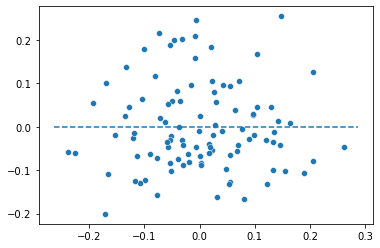

In [8]:
# Shockingly there is no plot function to plot via slope and intercept.
# We create our own

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

# set intercept
b_0 = model.intercept_[0]
b_1 = model.coef_[0][0]

# Lets plot the line on the data
sns.scatterplot(x=x, y=y)

# plotting y = b_0 + b_1 * x
abline(b_1, b_0)

What is $R^2$? Since $x$ and $y$ are orthogonal... a projection onto the colspace of $X$ gets annihilated.

In [9]:
# R^2
model.score(x_df, y_df)

0.0

## Random correlations are non-zero

In [10]:
# Set seed
np.random.seed(420)

# define x and y
x = [np.random.normal(0, 1) for i in range(n)]
x = x - np.mean(x)

y = [np.random.normal(0, 1) for i in range(n)]
y = y - np.mean(y)

print(x[0:5])
print(y[0:5])

[-0.34524215 -1.76500514 -0.3860731  -0.17339732  0.4708552 ]
[ 0.08436104  0.80402293 -0.78987475  0.16513643 -0.4114791 ]


In this setup, $x$ and $y$ are centered Gaussian random vectors. Are they orthogonal?

In [11]:
x @ y

8.414895305006766

Their product isn't zero. What is the degree between the planes?

In [12]:
# theta in radians
theta_in_rad = np.arccos(x @ y / np.sqrt(sum(x**2) * sum(y**2)))
theta_in_rad

1.4719722411108414

In [10]:
# theta in degrees
theta_in_deg = theta_in_rad * 180 / np.pi
theta_in_deg

84.33779697606442

They're not orthogonal. How are they correlated?

In [13]:
# correlation
print(np.corrcoef(x, y)[0, 1])

# R^2
print(np.corrcoef(x, y)[0, 1]**2)

0.09866330825056085
0.009734448394945189


They are *nearly* uncorrelated but they still have some correlation. How is this possible? 

There is "random chance"" AKA "chance capitalization"!

What about the best fitting line?

In [14]:
# initialize model
model = LinearRegression(fit_intercept = True)

x_df = pd.DataFrame(x)
y_df = pd.DataFrame(y)

# fit model
model.fit(x_df, y_df) # cast them to df objects

# print b0
print(model.intercept_)

# print coefficient
print(model.coef_)

[1.81951308e-17]
[[0.08857929]]


Lets visualize it.

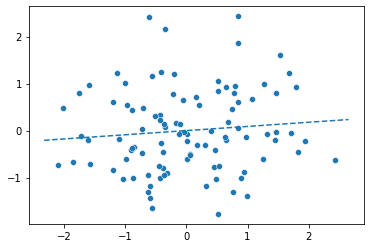

In [15]:
# set intercept
b_0 = model.intercept_[0]
b_1 = model.coef_[0][0]

# Lets plot the line on the data
sns.scatterplot(x=x, y=y)

# plotting y = b_0 + b_1 * x
abline(b_1, b_0)

Slope is about 0.08 which is small but non-zero.

What is $R^2$? Since $x$ and $y$ are nearly orthogonal... a projection onto the colspace of $X$ gets nearly annihilated.

In [16]:
model.score(x_df, y_df)

0.009734448394945083

but not entirely. Lesson learned: random noise can be correlated with the response $y$ and give you the illusion of fit!

## The monotonicity of SSR (or $R^2$) with more features

As $p$ increases, $R^2$ goes up. Here's a nice exercise:

In [17]:
n = 200
Rsqs = [0] # the rsq of y ~ x is 0

# Set seed
np.random.seed(1640)

# define x and y
y = [np.random.normal(0, 1) for i in range(n)]
y = pd.DataFrame(y)

x = [[1, np.random.normal(0, 1)] for i in range(n)]
X = pd.DataFrame(x)

for i in range(1, n):
    # adding column
    X[i+1] = [np.random.normal(0, 1) for j in range(n)]
    
    # fitting model
    model = LinearRegression(fit_intercept = True)
    model.fit(X, y) # cast them to df objects
    
    # add new Rsq to list
    Rsqs += [model.score(X, y)]
    
# see if all 200 Rsqs were collected
len(Rsqs)

200

Now let's plot it and see what happens:

<AxesSubplot:xlabel='Step', ylabel='R-Squared'>

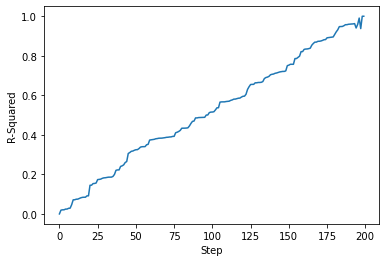

In [18]:
iteration = [i for i in range(n)]

df = pd.DataFrame({"Step":iteration,
                  "R-Squared":Rsqs})

sns.lineplot(data = df, x = "Step", y = "R-Squared")

With each additional predictor, what happens to $R^2$?

<AxesSubplot:xlabel='Step', ylabel='Delta R-Squared'>

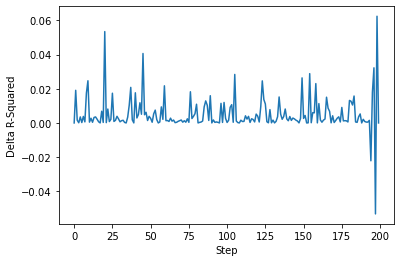

In [19]:
delta_Rsqs = [0 if i == 0 else Rsqs[i] - Rsqs[i-1] for i in range(0, n)]

df = pd.DataFrame({"Step":iteration,
                  "Delta R-Squared":delta_Rsqs})

sns.lineplot(data = df, x = "Step", y = "Delta R-Squared")

How can this possibly be?? The $x$'s are not related to $y$ whatsoever!!

Chance capitalization prevails. Each additional predictor picks up another dimension to add to the column space of $X$. Eventually, the projection explains *all* the variance. If $n = p + 1$, that matrix is square and of full rank, hence $\hat{y} = y$ and all residuals $e = 0$ since it is merely solving $n$ linearly independent equations.

So here's an idea. To get a perfect fit, just augment your design matrix with $n - (p + 1)$ random vectors and you get $R^2 = 100\%$! There must be something wrong with this.

Even if $p$ is large and $<n$, you are getting a lot of fit for free. So there's something wrong with this too!

This is called overfitting.

## Overfitting

Let's see how overfitting increases generalized estimation error.

We're gonna try to fit our betas in an effort to get $g$ as close to $h_*$ as possible but actually our g is going to get worse and worse as we load in garbage features.

In [20]:
# Set seed
#np.random.seed(1)
bbeta = [1] # h_*

# Building Train Data
n = 100

X = [1, np.random.normal(0, 1)]
X = pd.DataFrame(X)

y = X @ bbeta + np.random.normal(0, 30) # here we add some random noise, the first term alone is the true y
y = pd.DataFrame(y)

In [21]:
all_betas = np.empty(shape = (n, n))

# fitting model
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
print( model.coef_[0])

for i in range(1):
    generated_b = model.coef_[0][i]
    all_betas[0, i] = generated_b  

# get yhat
#yhat = model.predict(X)

yhat = X @ np.asarray(all_betas[[0], 0:1])
# add new RMSE to list
#RMSE = np.sqrt(mean((y - yhat)**2))

print(np.sqrt(np.mean((y - pd.DataFrame(yhat))**2))[0])
print(mean_squared_error(y_true=y, y_pred=yhat, squared=False))

[2.58779968]
9.880755579521473
9.880755579521473


In [22]:
model.score(X, y)

-126.3501545778198

In [23]:
X.iloc[:, 0:3]

,0
0,1.000000
1,-0.751138


In [28]:
# Calculating in sample RMSE metrics
import math

# Set seed
#np.random.seed(2000)
bbeta = [1, 2, 3, 4] # h_*

# Building Train Data
n = 10

X = [[1, np.random.normal(), np.random.normal(), np.random.normal()] for i in range(n)]
X = pd.DataFrame(X)
print(X.shape)

y = X @ bbeta + np.random.normal(0, .3) # here we add some random noise, the first term alone is the true y
y = pd.DataFrame(y)

# all the coefficients
all_betas = np.empty(shape = (n, n))
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
    
# List of RMSE values
in_sample_rmse = [0, 0, 0, 0]
rsq = [0, 0, 0, 0]

# Each iteration we add another garbage column and record the RMSE
for i in range(4, n):
    
    # fitting model
    model = LinearRegression(fit_intercept = False)
    model.fit(X, y)
    
    # Update the all_betas matrix
    for k in range(i):
        generated_b = model.coef_[0][k]
        all_betas[i, k] = generated_b
    
    # get yhat
    yhat = X @ np.asarray(all_betas[i, 0:i])
    
    # add new RMSE to list
    RMSE = math.sqrt(((y - pd.DataFrame(yhat))**2).mean())
    #RMSE = mean_squared_error(y_true=y, y_pred=yhat, squared=False)
    in_sample_rmse += [RMSE]
    rsq += [model.score(X, y)]
    
    # adding column
    X[i] = [np.random.normal(0, 1) for j in range(n)]

(10, 4)


In [25]:
X

,0,1,2,3,4,5,6,7,8,9
0,1,0.166320,0.727994,0.331717,0.726295,0.014287,-0.442941,-0.134026,0.466746,-0.548269
1,1,0.971687,-1.316008,-0.297569,-0.875635,-2.072839,-1.534979,0.562164,-0.657256,-0.583933
2,1,-1.349091,-0.981522,1.144307,0.327100,-0.148184,-0.614767,-2.504987,-1.247470,-1.330641
3,1,-2.037137,-0.082677,0.201713,-0.674199,0.898246,-0.954010,2.388965,1.196857,-1.378643
4,1,0.868920,0.516596,-0.140266,0.075347,1.051541,0.597305,0.383844,-1.545248,-0.149525
5,1,0.097701,-0.507407,0.434962,-0.565838,1.419451,-1.900858,-1.212081,0.875708,-0.539050
6,1,-0.874498,-1.076396,-1.597601,0.895081,0.695349,-0.832339,0.173609,-1.886739,0.487281
7,1,-0.864564,0.447902,-0.085389,0.617046,1.494711,0.281516,0.192992,0.343247,-0.735670
8,1,-0.075893,-1.840804,0.522758,-0.556720,-0.468842,0.926964,-1.013105,0.942864,-0.846474
9,1,-0.369955,0.341661,1.334422,1.303671,-0.296377,-0.372676,-0.805030,-0.190271,-0.338007


In [26]:
pd.DataFrame(all_betas).head(30)

,0,1,2,3,4,5,6,7,8,9
0,2.121996e-314,6.365987e-314,1.060998e-313,1.485397e-313,1.909796e-313,2.334195e-313,2.758595e-313,3.182994e-313,3.607393e-313,4.031792e-313
1,4.456191e-313,4.880590e-313,5.304989e-313,5.729389e-313,6.153788e-313,6.578187e-313,7.002586e-313,7.426985e-313,7.851384e-313,8.275784e-313
2,8.700183e-313,9.124582e-313,9.548981e-313,9.973380e-313,1.039778e-312,1.082218e-312,1.124658e-312,1.167098e-312,1.209538e-312,1.251978e-312
3,1.294417e-312,1.336857e-312,1.379297e-312,1.421737e-312,1.464177e-312,1.506617e-312,1.549057e-312,1.591497e-312,1.633937e-312,1.676377e-312
4,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,1.888576e-312,1.931016e-312,1.973456e-312,2.015896e-312,2.058336e-312,2.100776e-312
5,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,4.609679e-15,2.355415e-312,2.397855e-312,2.440295e-312,2.482735e-312,2.525175e-312
6,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,-5.217976e-15,1.184199e-14,2.822254e-312,2.864694e-312,2.907134e-312,2.949574e-312
7,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,-7.446731e-16,4.582641e-16,4.547368e-15,3.289093e-312,3.331533e-312,3.373973e-312
8,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,2.432412e-16,3.940711e-15,-3.545601e-15,3.021277e-15,3.755933e-312,3.798372e-312
9,2.174022e+01,2.000000e+00,3.000000e+00,4.000000e+00,-3.565979e-15,1.173954e-14,1.033203e-14,7.034943e-15,-4.806934e-15,4.222772e-312


In [27]:
in_sample_rmse

[0,
 0,
 0,
 0,
 8.198228413799545e-15,
 4.7994518887528756e-15,
 2.2384915612894026e-14,
 9.745709465637164e-15,
 8.407255028117242e-15,
 2.7340895994598107e-14]

In [29]:
len(in_sample_rmse)

10

<AxesSubplot:xlabel='Num_of_Features', ylabel='In_Sample_RMSE'>

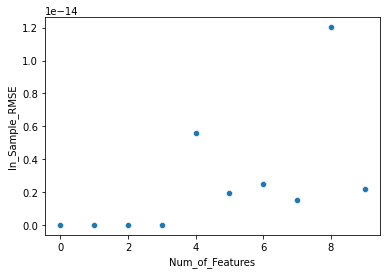

In [30]:
df = pd.DataFrame({"Num_of_Features":[i for i in range(n)],
                   "In_Sample_RMSE":in_sample_rmse})

sns.scatterplot(data = df, x = "Num_of_Features", y = "In_Sample_RMSE")